Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [89]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_forward_general"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80
MINDEST_POTENTIAL = 0
CENTRAL = 1
OFFENSE = 1

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']

PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','Composure','Interceptions',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'BallControl',  'SprintSpeed', 'Agility',
       'Reactions',  'ShotPower', 'Jumping',  'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  'HeadingAccuracy']

# PLAYER_ATTRIBUTES = ['FKAccuracy','HeadingAccuracy',
#        'ShortPassing',  'Dribbling',  
#         'BallControl',  'SprintSpeed', 
#        'Reactions',    'Strength',
#        'LongShots', 'Aggression',  'Positioning', 'Vision'
# ]


In [90]:
%load_ext autoreload
%autoreload 2

import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")

find_and_append_module_path()

import os
import warnings
from datetime import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

from prediction_prime_overall.src.prepare import (
    add_features_raw,
    select_features
)
from prediction_prime_overall.src.eval import (
    plot_feature_importance,
    plot_shap_summary,
    plot_auc_curves,
    log_metrics_in_mlflow_regression,
    log_metrics_in_mlflow,
    log_feature_list_as_artifact
)
import prediction_prime_overall.config as CONFIG
from prediction_prime_overall.src.utils import *


mlflow.set_tracking_uri("file:///"+CONFIG.MLFLOW)
mlflow.set_experiment(EXPERIEMENT_NAME)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
New current directory: c:\Users\Robert\Documents\Projekte\statsfaction


<Experiment: artifact_location='file:///c:\\Users\\Robert\\Documents\\Projekte\\statsfaction\\prediction_prime_overall\\data\\mlflow/376607792081155292', creation_time=1702071048864, experiment_id='376607792081155292', last_update_time=1702071048864, lifecycle_stage='active', name='offense_potential_forward_general', tags={}>

### Get Data

In [91]:
sql_prime = """
SELECT min(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={MINDEST_POTENTIAL})
GROUP BY ID
order by potential DESC;
"""



In [92]:


# Step 1: Establish a database connection
conn = sqlite3.connect(CONFIG.DATABASE)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw(df_raw)

df_raw.head()


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,NaN,NaN,95.0,25.0,94.0,RW,0,1,1.0,13.0
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,84.0,35.0,91.0,20.0,78.0,RW,0,1,1.0,35.0
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0


# 

In [93]:
# df_raw["Potential"] = df_raw.Potential.astype('float')
# df_raw["max_potential"] = df_raw.max_potential.astype('float')

In [94]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [95]:
df = df[(df.central == CENTRAL)&(df.offense ==OFFENSE)]

# Training nur auf High Potentials
df = df[df.max_potential>MINDEST_POTENTIAL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
66.0    178
65.0    177
69.0    174
68.0    173
63.0    169
70.0    167
67.0    165
64.0    162
62.0    131
71.0    129
72.0    128
73.0    121
61.0    114
74.0    109
60.0     99
75.0     90
58.0     79
59.0     77
76.0     68
78.0     65
77.0     54
55.0     50
56.0     49
54.0     38
57.0     33
79.0     33
80.0     30
53.0     25
81.0     23
82.0     18
83.0     14
84.0     13
50.0     11
51.0     10
52.0     10
86.0      4
87.0      3
88.0      3
89.0      3
90.0      2
47.0      2
91.0      1
85.0      1
92.0      1
49.0      1
Name: count, dtype: int64


In [96]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
186405,F. di Santo,2011,21.0,21.0,27.0,90.0,90.0,74.0,77.0,77.0,drop,ST
199266,Ji Dong Won,2011,19.0,19.0,22.0,89.0,89.0,66.0,72.0,72.0,drop,ST
240833,Y. Moukoko,2023,17.0,17.0,18.0,88.0,88.0,69.0,77.0,77.0,valid,ST
231677,M. Rashford,2017,18.0,18.0,25.0,88.0,88.0,76.0,84.0,84.0,train,ST
225719,K. Iheanacho,2017,19.0,19.0,24.0,88.0,88.0,74.0,78.0,78.0,train,ST


In [97]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [98]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Att. Position', 'Composure', 'Defensive awareness'], dtype='object')

#### Transform Value

In [99]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

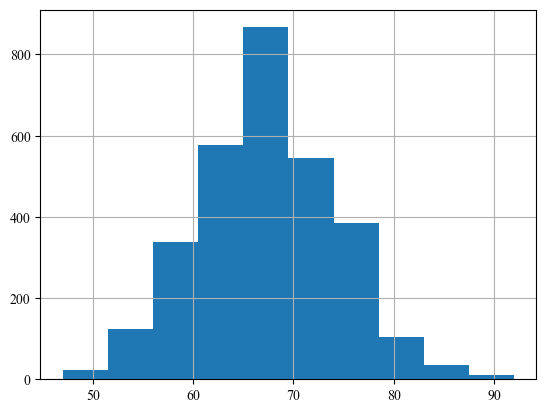

In [100]:
df['target'].hist()

In [101]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [102]:
df_processed.columns

Index(['potential_age', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Position', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Att. Position', 'Composure', 'Defensive awareness', 'max_potential',
       'prime_age', 'PrimeOverall', 'best_position', 'central', 'winger',
       'offense', 'Defense', 'set', 'target'],
      dtype='object')

In [103]:
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [104]:
y_train.describe()

count    1847.000000
mean       67.205739
std         6.858807
min        47.000000
25%        63.000000
50%        67.000000
75%        72.000000
max        91.000000
Name: target, dtype: float64

In [105]:


# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')


# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [106]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [107]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [108]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


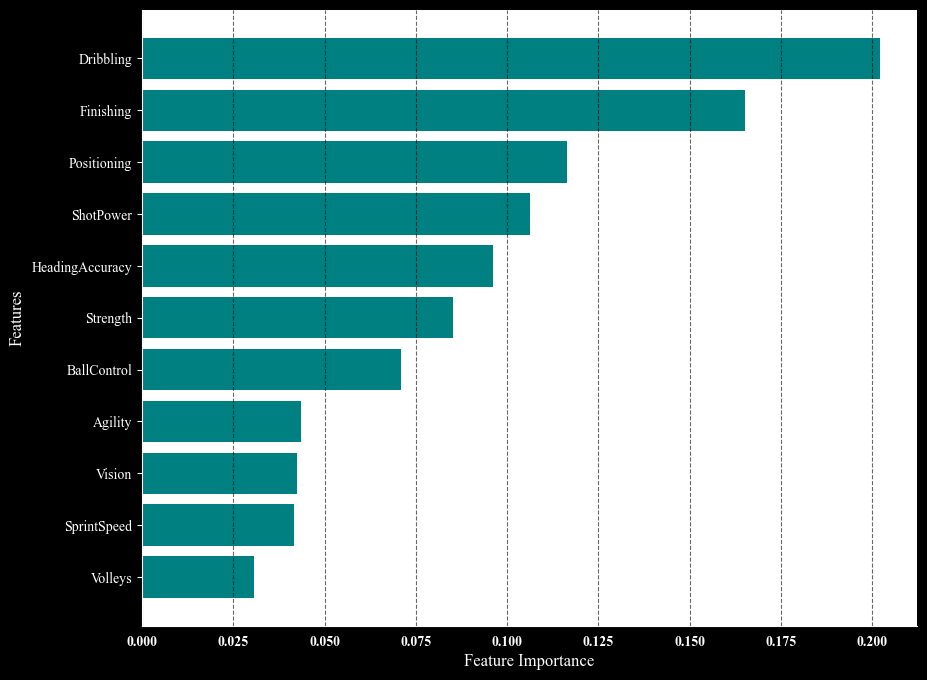

Using 380 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [02:01<00:00,  4.04s/it]


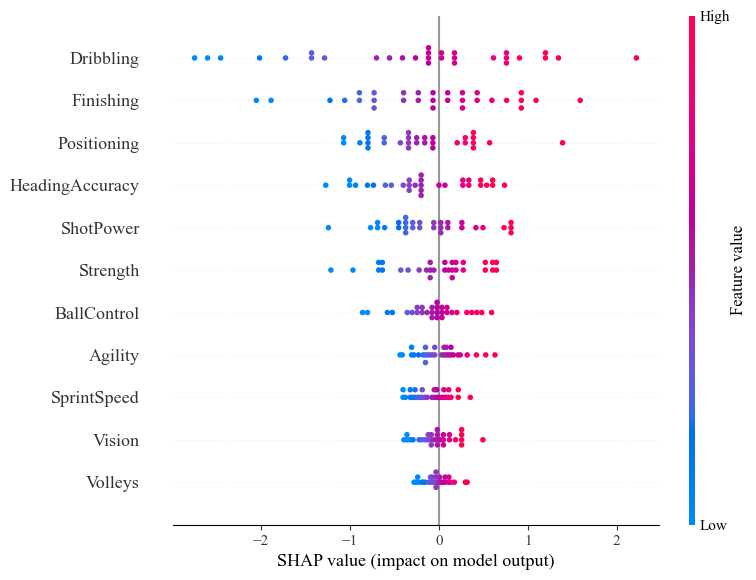

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       374
        True       0.00      0.00      0.00         6

    accuracy                           0.98       380
   macro avg       0.49      0.50      0.50       380
weighted avg       0.97      0.98      0.98       380

Huber Regression training----->


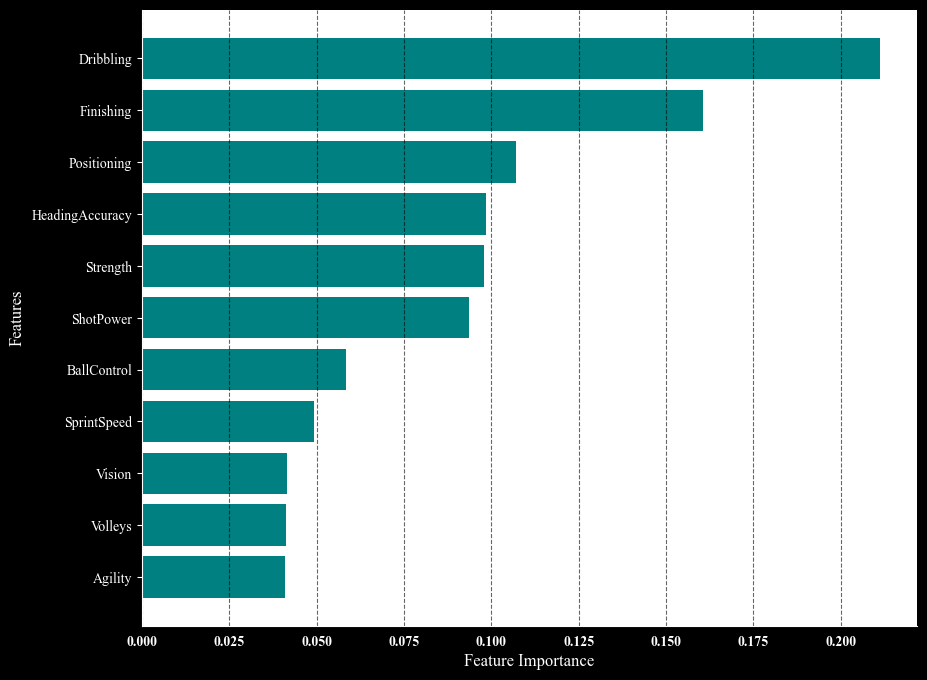

Using 380 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [01:42<00:00,  3.43s/it]


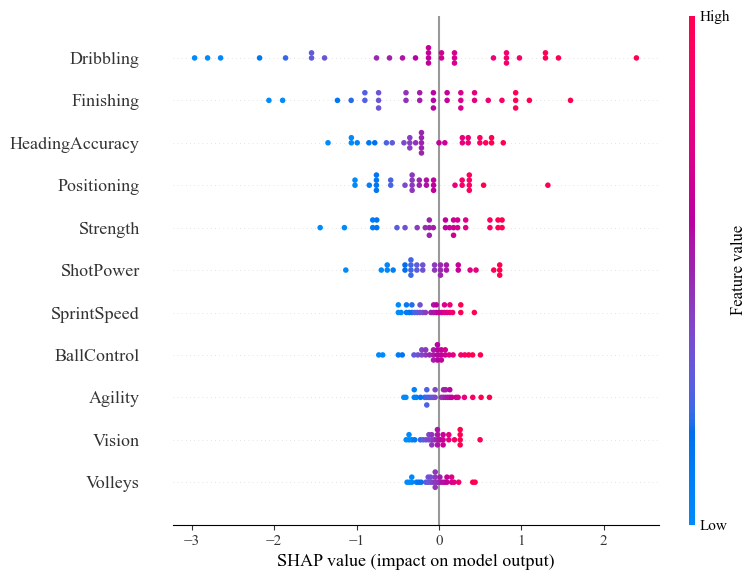

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       374
        True       0.00      0.00      0.00         6

    accuracy                           0.98       380
   macro avg       0.49      0.50      0.50       380
weighted avg       0.97      0.98      0.98       380

Linear Regression training----->


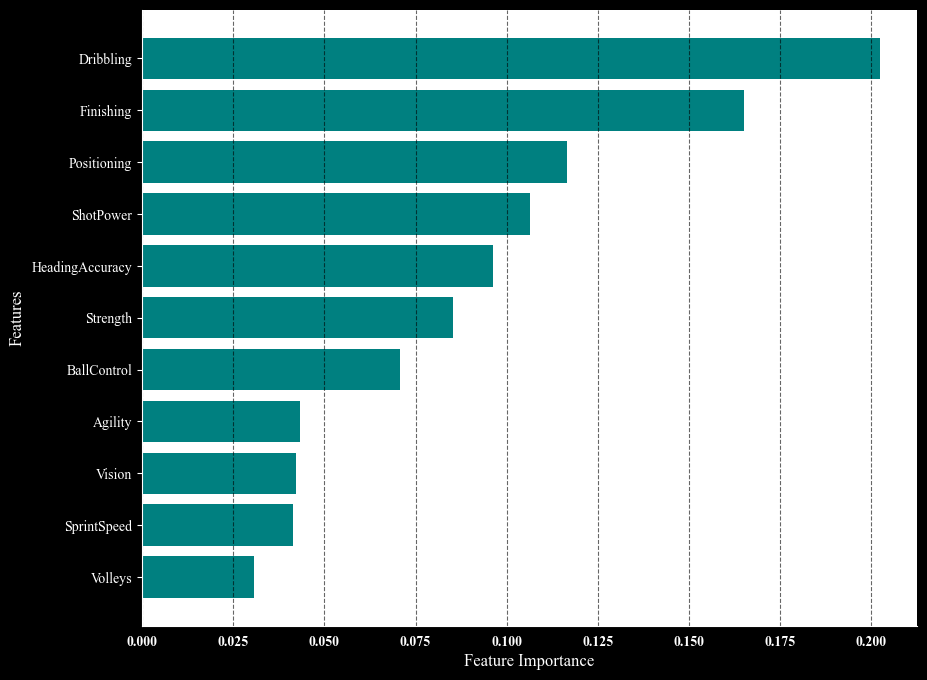

Using 380 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [01:41<00:00,  3.38s/it]


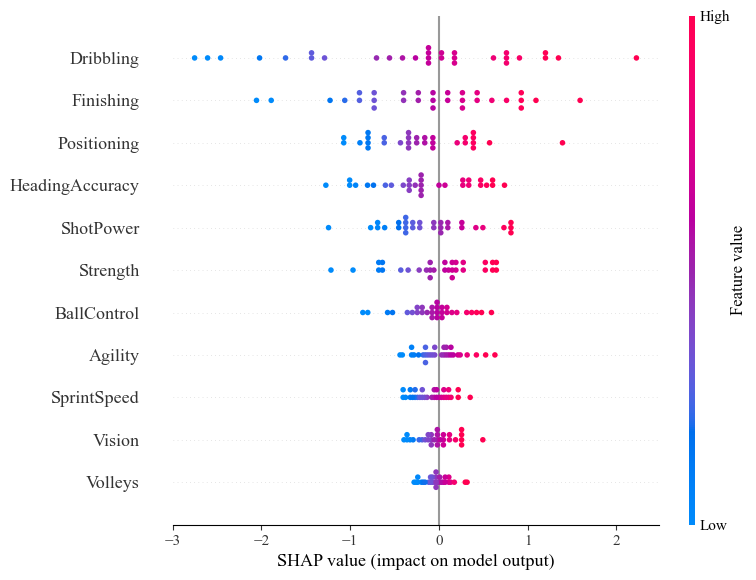

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       374
        True       0.00      0.00      0.00         6

    accuracy                           0.98       380
   macro avg       0.49      0.50      0.50       380
weighted avg       0.97      0.98      0.98       380

Model: Ridge Regression
Mean Squared Error: 21.77
Mean Absolute Error: 3.90
R2 Score: 0.42

Model: Huber Regression
Mean Squared Error: 20.28
Mean Absolute Error: 3.70
R2 Score: 0.46

Model: Linear Regression
Mean Squared Error: 21.77
Mean Absolute Error: 3.90
R2 Score: 0.42



In [109]:



regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    #  'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    #  'XGBoost Regressor': XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}

# Set the experiment name

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        

        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [110]:

if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [111]:
X_train.describe()

,Crossing,Finishing,Composure,Interceptions,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,BallControl,...,Reactions,ShotPower,Jumping,Strength,LongShots,Aggression,Positioning,Vision,Penalties,HeadingAccuracy
count,1847.00000,1847.000000,1847.000000,1847.000000,1847.000000,1847.00000,1847.000000,1847.000000,1847.000000,1847.000000,...,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000
mean,38.75582,61.212777,17.316730,22.704385,50.589063,49.70222,57.408230,44.519220,37.547374,57.734705,...,54.930698,59.231727,63.600433,60.171088,53.320520,41.629128,56.955062,48.963184,58.756362,56.551705
std,10.10280,6.218197,24.536877,8.273906,8.385844,9.30948,8.628865,10.168011,9.972106,7.910524,...,7.419453,8.390484,9.093862,12.845737,7.390745,12.908734,7.959992,7.724449,7.890583,8.942782
min,18.00000,38.000000,0.000000,10.000000,10.000000,25.00000,33.000000,20.000000,16.000000,28.000000,...,28.000000,37.000000,23.000000,22.000000,15.000000,16.000000,30.000000,12.000000,21.000000,21.000000
25%,31.00000,57.000000,0.000000,17.000000,44.000000,43.00000,51.000000,37.000000,30.000000,52.000000,...,50.000000,53.000000,59.000000,52.000000,48.000000,31.000000,51.500000,44.000000,55.000000,51.000000
50%,36.00000,61.000000,0.000000,22.000000,50.000000,49.00000,58.000000,43.000000,35.000000,58.000000,...,54.000000,59.000000,64.000000,60.000000,53.000000,38.000000,56.000000,48.000000,60.000000,57.000000
75%,45.00000,65.000000,46.000000,25.000000,57.000000,56.00000,63.000000,51.000000,43.000000,63.000000,...,59.000000,65.000000,69.000000,70.000000,58.000000,52.000000,62.000000,54.000000,64.000000,63.000000
max,70.00000,78.000000,78.000000,60.000000,80.000000,80.00000,86.000000,81.000000,75.000000,84.000000,...,82.000000,87.000000,94.000000,93.000000,77.000000,88.000000,85.000000,76.000000,84.000000,83.000000


In [112]:
y_test.describe()

count    380.000000
mean      65.600000
std        6.160818
min       50.000000
25%       62.000000
50%       66.000000
75%       70.000000
max       86.000000
Name: target, dtype: float64

In [113]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [114]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

380

<Axes: >

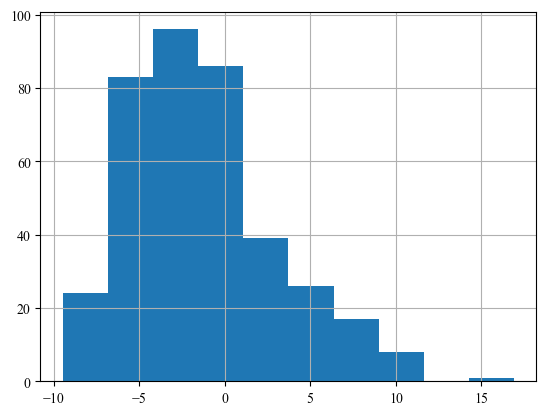

In [115]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

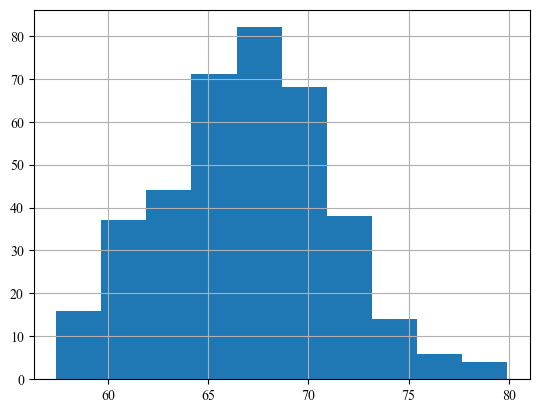

In [116]:
result_df.sort_values(ascending=False).hist()

In [117]:
(y_test-result_df).describe()

count    380.000000
mean      -1.297469
std        4.317923
min       -9.459121
25%       -4.474363
50%       -1.945505
75%        0.978776
max       16.906098
dtype: float64

In [118]:
outlier = (y_test-result_df)>10
X_test[outlier]


,,,Crossing,Finishing,Composure,Interceptions,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,BallControl,...,Reactions,ShotPower,Jumping,Strength,LongShots,Aggression,Positioning,Vision,Penalties,HeadingAccuracy
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
246430,D. Vlahovic,2020,41.0,65.0,55.0,12.0,60.0,47.0,55.0,41.0,37.0,55.0,...,54.0,62.0,65.0,63.0,55.0,41.0,58.0,53.0,65.0,62.0
251892,Beto,2021,39.0,63.0,66.0,11.0,52.0,65.0,59.0,56.0,32.0,63.0,...,60.0,70.0,58.0,85.0,59.0,66.0,61.0,45.0,65.0,64.0
247679,V. Boniface,2020,30.0,57.0,47.0,17.0,49.0,54.0,58.0,50.0,30.0,52.0,...,48.0,55.0,67.0,43.0,54.0,34.0,47.0,48.0,69.0,47.0
252324,Riquelme,2020,49.0,62.0,60.0,41.0,62.0,57.0,63.0,49.0,44.0,64.0,...,62.0,58.0,55.0,47.0,59.0,58.0,65.0,61.0,55.0,46.0


In [119]:
y_test[outlier]

ID      Name         FIFA
246430  D. Vlahovic  2020    84.0
251892  Beto         2021    81.0
247679  V. Boniface  2020    74.0
252324  Riquelme     2020    78.0
Name: target, dtype: float64

In [120]:
result_df[outlier]

ID      Name         FIFA
246430  D. Vlahovic  2020    67.093902
251892  Beto         2021    69.552034
247679  V. Boniface  2020    63.794913
252324  Riquelme     2020    67.721047
dtype: float64

In [121]:
(y_test/result_df).describe()

count    380.000000
mean       0.980421
std        0.065988
min        0.845745
25%        0.934461
50%        0.970187
75%        1.013820
max        1.251977
dtype: float64

In [122]:
(y_test/result_df).describe()

count    380.000000
mean       0.980421
std        0.065988
min        0.845745
25%        0.934461
50%        0.970187
75%        1.013820
max        1.251977
dtype: float64

In [123]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.71368522],
       [0.71368522, 1.        ]])

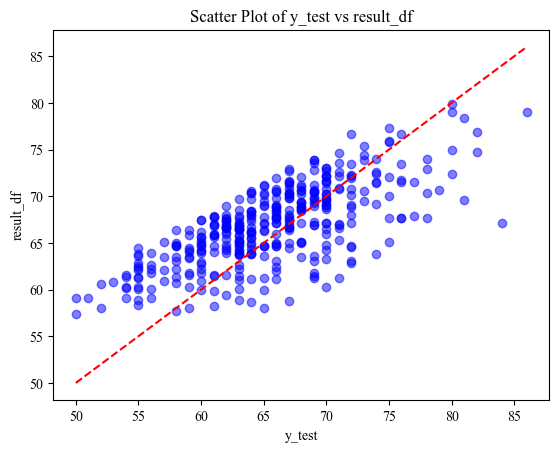

In [124]:

plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [125]:
result_df = result_df.sort_values(ascending=False)

In [126]:
sum(X_train_scaled_df.index.get_level_values('ID')==239085)

1

In [127]:
df_raw

,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,NaN,NaN,95.0,25.0,94.0,RW,0,1,1.0,13.0
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,84.0,35.0,91.0,20.0,78.0,RW,0,1,1.0,35.0
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152923,A. Prent,2011,27.0,27.0,https://cdn.sofifa.net/players/152/923/11_60.png,Netherlands,https://cdn.sofifa.net/flags/nl.png,62.0,65.0,Halmstad,https://cdn.sofifa.net/meta/team/720/30.png,€0,...,NaN,NaN,65.0,27.0,62.0,RF,0,1,1.0,36.0
165667,Ł. Janoszka,2011,23.0,23.0,https://cdn.sofifa.net/players/165/667/11_60.png,Poland,https://cdn.sofifa.net/flags/pl.png,56.0,63.0,Ruch Chorzów,https://cdn.sofifa.net/meta/team/2561/30.png,€0,...,NaN,NaN,63.0,29.0,68.0,RF,0,1,1.0,21.0
184406,L. Martínez,2011,20.0,20.0,https://cdn.sofifa.net/players/184/406/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,60.0,62.0,AlbinoLeffe,https://cdn.sofifa.net/meta/team/10735/30.png,€0,...,NaN,NaN,62.0,20.0,60.0,RF,0,1,1.0,26.0


In [128]:
result_df.head(50)

ID      Name               FIFA
231447  D. Malen           2020    79.923832
241721  Rafael Leão        2020    79.053705
246186  Arthur Cabral      2021    79.022346
243630  J. David           2020    78.430402
254247  M. Mohamed         2021    77.351649
253072  D. Núñez           2021    76.839504
244797  P. Musa            2021    76.668385
230516  Paulao Junqueiras  2021    76.634814
245940  S. Wamangituka     2020    75.944051
246762  S. Koita           2021    75.844535
252042  João Pedro         2021    75.374810
251852  K. Adeyemi         2021    75.007653
246242  B. Dia             2020    74.757050
245396  V. Supryaga        2021    74.656383
252037  Fábio Silva        2020    74.443334
251470  C. De Ketelaere    2021    73.955401
246690  A. Bareiro         2020    73.940408
243315  Dani Gómez         2020    73.890695
250818  Anderson Oliveira  2021    73.848604
252865  Iker Losada        2021    73.838639
251105  D. Joveljić        2020    73.596172
245762  A. Kutucu      

In [129]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

0


Series([], dtype: float64)

In [130]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

10


ID      Name           FIFA
231447  D. Malen       2020    79.923832
241721  Rafael Leão    2020    79.053705
246186  Arthur Cabral  2021    79.022346
243630  J. David       2020    78.430402
253072  D. Núñez       2021    76.839504
251852  K. Adeyemi     2021    75.007653
246242  B. Dia         2020    74.757050
246191  J. Álvarez     2020    72.382098
251892  Beto           2021    69.552034
246430  D. Vlahovic    2020    67.093902
dtype: float64

In [131]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

0


Series([], dtype: float64)

In [132]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

370


ID      Name               FIFA
246147  M. Greenwood       2020    72.935572
245124  D. Jovanović       2020    72.979331
241602  J. Arias           2020    73.069520
242998  Klauss             2020    73.490676
241522  J. Wind            2020    73.502734
245762  A. Kutucu          2020    73.515349
251105  D. Joveljić        2020    73.596172
252865  Iker Losada        2021    73.838639
250818  Anderson Oliveira  2021    73.848604
243315  Dani Gómez         2020    73.890695
246690  A. Bareiro         2020    73.940408
251470  C. De Ketelaere    2021    73.955401
252037  Fábio Silva        2020    74.443334
245396  V. Supryaga        2021    74.656383
252042  João Pedro         2021    75.374810
246762  S. Koita           2021    75.844535
245940  S. Wamangituka     2020    75.944051
230516  Paulao Junqueiras  2021    76.634814
244797  P. Musa            2021    76.668385
254247  M. Mohamed         2021    77.351649
dtype: float64

In [133]:

print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.95      0.98      0.96       357
        True       0.33      0.17      0.23        23

    accuracy                           0.93       380
   macro avg       0.64      0.58      0.60       380
weighted avg       0.91      0.93      0.92       380



In [134]:
X_train[X_train.index.get_level_values('ID')==239085]

,,,Crossing,Finishing,Composure,Interceptions,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,BallControl,...,Reactions,ShotPower,Jumping,Strength,LongShots,Aggression,Positioning,Vision,Penalties,HeadingAccuracy
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
239085,E. Håland,2018,42.0,59.0,48.0,15.0,46.0,51.0,58.0,67.0,33.0,57.0,...,52.0,56.0,67.0,66.0,55.0,67.0,53.0,49.0,60.0,56.0
